# Project: Plant Seedlings Classicication.

### Data Description:

- You are provided with a training set and a test set of images of plant seedlings at various stages of grown. 
- Each image has a filename that is its unique id. 
- The dataset comprises 12 plant species.
- The goal of the competition is to create a classifier capable of determining a plant's species from a photo.

### Dataset:
- The project is from a dataset from Kaggle.
- Link to the Kaggle project site:https://www.kaggle.com/c/plant-seedlings-classification/data
- The dataset has to be downloaded from the above Kagglewebsite.

### Context:

- Can you differentiate a weed from a crop seedling?
- The ability to do so effectively can mean better crop yields and better stewardship of the environment.
- The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 species at several growth stages.

### Objective:
- To implement the techniques learnt as a part of the course.

### Learning Outcomes:
- Pre-processing of image data.
- Visualization of images.
- Building CNN.
- Evaluate the Model.

# Import Libraries and Data Load

In [215]:
# Import necessary libraries.
import cv2
import math
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, 
    Dropout, 
    Flatten, 
    Conv2D, 
    MaxPooling2D, 
    MaxPool2D,
    GlobalMaxPooling2D,
    BatchNormalization
)
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Set the path to the dataset folder. (The dataset contains image folder: "train")
base_path = '/content/drive/My Drive/'
train_path = base_path+"data/plant-seedlings-classification.zip"
extract_path = base_path+'data/Extracted/' # To extract the above seeding classification zip
save_extracted = base_path+'data/Save/'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Make different folders for train and test data in the current directory of Google Colab notebook. (using mkdir)
!mkdir extract_path

# Unziping train file:

In [ ]:
# Extract the files from dataset to temp_train and temp_test folders (as the dataset is a zip file.)
from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall(extract_path)

In [ ]:
# Extract Image and Label
def get_data(path):
  files = glob(path)

  trainImg = []                                              # Initialize empty list to store the image data as numbers.
  trainLabel = []                                            # Initialize empty list to store the labels of images
  j = 1
  num = len(files)
  print("Total #:",num)
  # Obtain images and resizing, obtain labels
  for img in files:
      '''
      Append the image data to trainImg list.
      Append the labels to trainLabel list.
      '''
      print(str(j) + "/" + str(num))
      trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
      trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
      j += 1

  trainImg = np.asarray(trainImg)  # Train images set
  trainLabel = pd.DataFrame(trainLabel)  # Train labels set
  return (trainImg, trainLabel)

# Extract Train dataset
path = extract_path+"train/*/*.png"    # The path to all images in training set. (* means include all folders and files.)
print('reading data from:',path)
trainImg, trainLabel = get_data(path)


In [134]:
print(f"Training image array shape:{trainImg.shape}")
print(f"Training target labels:{trainLabel.shape}")

Training image array shape:(4750, 128, 128, 3)
Training target labels:(4750, 1)


Storing the data into file to save the time in extract and read

In [ ]:
# Save data to file 
np.save(save_extracted+'trainImg.npy', trainImg)
np.save(save_extracted+'trainLabel.npy', trainLabel)

In [124]:
# Load data to file
trainImg = np.load(save_extracted+'trainImg.npy')
trainLabel = np.load(save_extracted+'trainLabel.npy', False, True)

trainImg.shape, trainLabel.shape

((4750, 128, 128, 3), (4750, 1))

# EDA

#### Explore the data by visualizing it from various categories

Image name:Black-grass


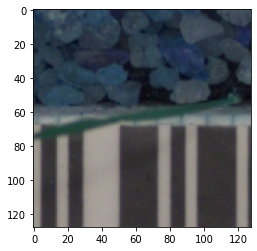

In [19]:
# Check Images
i = 0
img = trainImg[i]
label = trainLabel[0][i]
print(f'Image name:{label}')
plt.imshow(img)

Image name:Charlock


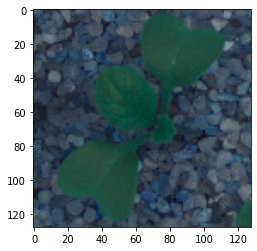

In [20]:
i = 500
img = trainImg[i]
label = trainLabel[0][i]
print(f'Image name:{label}')
plt.imshow(img)

Image name:Common Chickweed


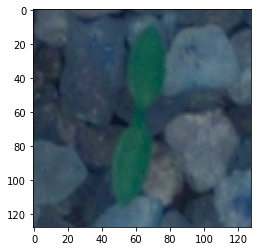

In [21]:
i = 1000
img = trainImg[i]
label = trainLabel[0][i]
print(f'Image name:{label}')
plt.imshow(img)

* Few training image has less quality, but it might overcome in pre-processing 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


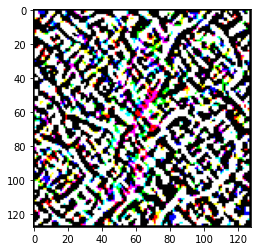

In [22]:
sobel = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=5)
plt.imshow(sobel)

# Pre-processing

### Normalize the Data
* The Data (Train image and testing image) needs to be normalized to 0-1 by diving the values by 255

In [136]:
trainImg = trainImg.astype('float32')
trainImg /= 255
# Check the nomalized data
print(f'Shape of the Train array:{trainImg.shape}')
print(f'Minimum value in the Train Array:{trainImg.min()}')
print(f'Maximum value in the Train Array:{trainImg.max()}')


Shape of the Train array:(4750, 128, 128, 3)
Minimum value in the Train Array:0.0
Maximum value in the Train Array:1.0


### Split the dataset
Split the dataset into training, testing, and validation set.
(Hint: First split train images and train labels into training and testing set with test_size = 0.3. Then further split test data into test and validation set with test_size = 0.5)

In [137]:
# Step#1: Split train and test set
X_train, X_test, y_train, y_test = train_test_split(trainImg, trainLabel, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((3325, 128, 128, 3), (1425, 128, 128, 3))

In [138]:
# Step#2: Split validation from test set
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_test.shape, X_validation.shape

((712, 128, 128, 3), (713, 128, 128, 3))

### One Hot encoding to target values

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_validation = encoder.fit_transform(y_validation)

* There is an alternate way to convert the target variable to one-hot
1. Convert String categorical to numeric
2. Use *tensorflow.keras.utils.to_categorical* to convert to binary array

In [141]:
# Display target variable
y_train[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

### Gaussian Blurring
Image blurring is achieved by convolving the image with a low-pass filter kernel. It is useful for removing noise. It actually removes high frequency content (e.g: noise, edges) from the image resulting in edges being blurred when this is filter is applied. 

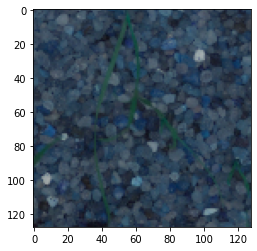

In [142]:
# Preview the image before Gaussian Blur
plt.imshow(X_train[0], cmap='gray')

In [ ]:
# Now we apply the gaussian blur to each 128x128 pixels array (image) to reduce the noise in the image
for idx, img in enumerate(X_train):
  X_train[idx] = cv2.GaussianBlur(img, (5, 5), 0)

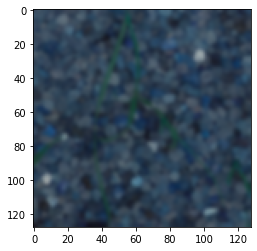

In [144]:
# Preview the image after Gaussian Blur
plt.imshow(X_train[0], cmap='gray')

In [ ]:
# Gaussian Blue to Test and Validation sets
for idx, img in enumerate(X_test):
  X_test[idx] = cv2.GaussianBlur(img, (5, 5), 0)

for idx, img in enumerate(X_validation):
  X_validation[idx] = cv2.GaussianBlur(img, (5, 5), 0)

# Create a Model

Steps:


1. Initialize CNN Classifier
2. Add Convolution layer with 32 kernels of 3x3 shape
3. Add Maxpooling layer of size 2x2
4. Flatten the input array
5. Add dense layer with relu activation function
6. Dropout the probability 
7. Add softmax Dense layer as output



In [ ]:
def create_model(input_shape, num_classes):
  # Initialize CNN Classified
  model = Sequential()

  # Add convolution layer with 32 filters and 3 kernels
  model.add(Conv2D(32, (3,3), input_shape=input_shape, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))

  # Add convolution layer with 32 filters and 3 kernels
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu))
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))

  # Add convolution layer with 32 filters and 3 kernels
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))

  # Flatten the 2D array to 1D array
  model.add(Flatten())

  # Create fully connected layers with 512 units
  model.add(Dense(512, activation=tf.nn.relu))
  model.add(Dropout(0.5))


  # Adding a fully connected layer with 128 neurons
  model.add(Dense(units = 128, activation = tf.nn.relu))
  model.add(Dropout(0.5))

  # The final output layer with 12 neurons to predict the categorical classifcation
  model.add(Dense(units = num_classes, activation = tf.nn.softmax))
  return model

* **Sequential:** Defines a Sequence of layers
* **Conv2D:** Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
* **MaxPool2D:** The objective is to down-sample an input representation
* **Flatten:** Convert the 2D to 1D array
* **Dense:** Adds a layers of neurons
* **Activation Functions:**:


> **Relu:** Relu effectively means "If X>0 return X, else return 0" -- so what it does it it only passes values 0 or greater to the next layer in the network.

> **Softmax:** takes a set of values, and effectively picks the biggest one, so, for example, if the output of the last layer looks like [0.1, 0.1, 0.05, 0.1, 9.5, 0.1, 0.05, 0.05, 0.05], it saves you from fishing through it looking for the biggest value, and turns it into [0,0,0,0,1,0,0,0,0] -- The goal is to save a lot of coding!




In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=10)

In [148]:
input_shape = X_train.shape[1:] # Input shape of X_train
num_classes = y_train.shape[1] # Target column size

model = create_model(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Optimizer
# optimizer = tf.keras.optimizers.SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 32, 32, 64)      

In [149]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=30, batch_size=100, callbacks=[callbacks])

Epoch 1/30
34/34 [==============================] - 2s 55ms/step - loss: 2.4634 - accuracy: 0.1170 - val_loss: 2.4509 - val_accuracy: 0.1487
Epoch 2/30
34/34 [==============================] - 1s 42ms/step - loss: 2.4291 - accuracy: 0.1365 - val_loss: 2.4064 - val_accuracy: 0.1487
Epoch 3/30
34/34 [==============================] - 1s 43ms/step - loss: 2.3733 - accuracy: 0.1871 - val_loss: 2.1376 - val_accuracy: 0.3604
Epoch 4/30
34/34 [==============================] - 1s 43ms/step - loss: 2.0137 - accuracy: 0.3290 - val_loss: 1.6826 - val_accuracy: 0.4194
Epoch 5/30
34/34 [==============================] - 1s 42ms/step - loss: 1.7338 - accuracy: 0.3877 - val_loss: 1.5014 - val_accuracy: 0.4867
Epoch 6/30
34/34 [==============================] - 1s 42ms/step - loss: 1.5819 - accuracy: 0.4391 - val_loss: 1.2956 - val_accuracy: 0.5975
Epoch 7/30
34/34 [==============================] - 1s 42ms/step - loss: 1.4333 - accuracy: 0.4971 - val_loss: 1.1821 - val_accuracy: 0.6199
Epoch 8/30
34

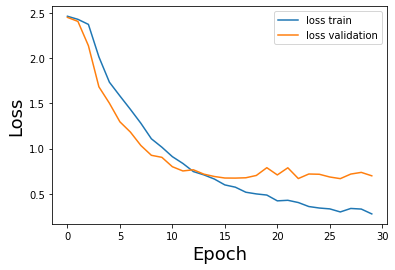

In [150]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel(r'Loss', fontsize=18)
plt.legend(('loss train','loss validation'), loc=0)

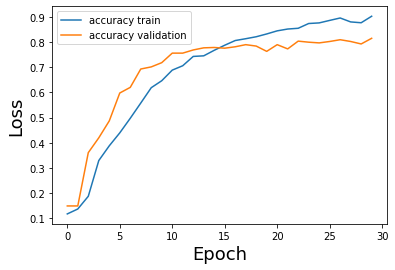

In [151]:

# Print accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel(r'Loss', fontsize=18)
plt.legend(('accuracy train','accuracy validation'), loc=0)

# Model Evaluation

In [152]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss: {:.2f} \n Test accuracy: {:.2f}'.format(loss, accuracy))

loss, accuracy = model.evaluate(X_train, y_train)
print('Train loss: {:.2f} \n Train accuracy: {:.2f}'.format(loss, accuracy))

23/23 [==============================] - 0s 7ms/step - loss: 0.7926 - accuracy: 0.7753
Test loss: 0.79 
 Test accuracy: 0.78
104/104 [==============================] - 1s 8ms/step - loss: 0.1244 - accuracy: 0.9546
Train loss: 0.12 
 Train accuracy: 0.95


* Model is overfitting since training accuracy is 95% and testing accuracy is 81%. let's stop it before 18 epoch

# Model Retrain

In [153]:
model1 = create_model(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Optimizer

model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 32, 32, 64)      

In [154]:
history = model1.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=18, callbacks=[callbacks])

Epoch 1/18
104/104 [==============================] - 2s 18ms/step - loss: 2.4413 - accuracy: 0.1236 - val_loss: 2.4093 - val_accuracy: 0.2511
Epoch 2/18
104/104 [==============================] - 2s 17ms/step - loss: 2.0512 - accuracy: 0.3032 - val_loss: 1.6454 - val_accuracy: 0.4502
Epoch 3/18
104/104 [==============================] - 2s 17ms/step - loss: 1.7086 - accuracy: 0.4024 - val_loss: 1.3713 - val_accuracy: 0.5273
Epoch 4/18
104/104 [==============================] - 2s 17ms/step - loss: 1.4476 - accuracy: 0.4980 - val_loss: 1.1346 - val_accuracy: 0.6396
Epoch 5/18
104/104 [==============================] - 2s 17ms/step - loss: 1.1962 - accuracy: 0.5841 - val_loss: 0.9762 - val_accuracy: 0.6942
Epoch 6/18
104/104 [==============================] - 2s 16ms/step - loss: 1.0947 - accuracy: 0.6301 - val_loss: 0.8625 - val_accuracy: 0.7181
Epoch 7/18
104/104 [==============================] - 2s 17ms/step - loss: 0.9474 - accuracy: 0.6698 - val_loss: 0.8136 - val_accuracy: 0.7279

In [155]:
loss, accuracy = model1.evaluate(X_test, y_test)
print('Test loss: {:.2f} \n Test accuracy: {:.2f}'.format(loss, accuracy))

loss, accuracy = model1.evaluate(X_train, y_train)
print('Train loss: {:.2f} \n Train accuracy: {:.2f}'.format(loss, accuracy))

23/23 [==============================] - 0s 8ms/step - loss: 0.8435 - accuracy: 0.7584
Test loss: 0.84 
 Test accuracy: 0.76
104/104 [==============================] - 1s 7ms/step - loss: 0.2290 - accuracy: 0.9113
Train loss: 0.23 
 Train accuracy: 0.91


* The early stopping helping model to balance accuracy b/w test and training. Let's save the mode for future re-training

In [ ]:
from keras.models import load_model
model.save(save_extracted+'final_model.h5')

In [ ]:
model.load_weights(save_extracted+'final_model.h5')

### Confusion matrix

In [ ]:
y_pred = model1.predict(X_test)
y_pred = (y_pred > 0.5) 

In [223]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

=== Confusion Matrix ===
[[ 7  0  0  0  5  1 29  0  0  0  0  0]
 [ 2 52  2  0  0  0  0  0  0  1  0  0]
 [ 2  1 37  0  0  3  0  1  0  0  0  0]
 [ 4  0  0 92  0  0  1  0  2  5  0  1]
 [10  0  0  0 12  3  3  0  1  0  0  1]
 [ 6  1  4  0  1 55  0  0  0  1  0  0]
 [ 7  0  0  0  3  3 74  0  3  0  1  1]
 [ 7  2  0  2  0  1  1 23  2  0  1  2]
 [ 9  4  4  1  0  1  1  0 41  0  0  3]
 [ 6  0  0  0  0  2  0  0  3 19  1  0]
 [ 3  2  0  0  0  0  0  0  2  0 68  1]
 [10  0  0  0  1  9  0  0  1  0  1 40]]


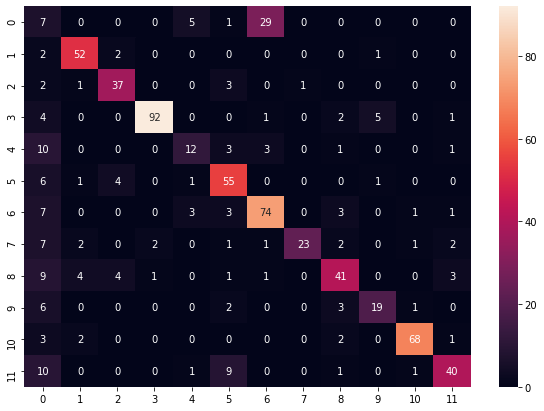

In [224]:
df_cm = pd.DataFrame(cm, index = [i for i in range(0,12)],
                     columns = [i for i in range(0,12)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')

In [222]:
print("=== Classification Report ===")
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.10      0.17      0.12        42
           1       0.84      0.91      0.87        57
           2       0.79      0.84      0.81        44
           3       0.97      0.88      0.92       105
           4       0.55      0.40      0.46        30
           5       0.71      0.81      0.75        68
           6       0.68      0.80      0.74        92
           7       0.96      0.56      0.71        41
           8       0.75      0.64      0.69        64
           9       0.73      0.61      0.67        31
          10       0.94      0.89      0.92        76
          11       0.82      0.65      0.72        62

    accuracy                           0.73       712
   macro avg       0.73      0.68      0.70       712
weighted avg       0.77      0.73      0.74       712



* **Precision**: Out of all the positive classes we have predicted correctly, how many are actually positive.
* **Recall**: Out of all the positive classes, how much we predicted correctly. It should be high as possible.
* **F1-Score**: F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution

### Visualize predictions

Predicted label: Small-flowered Cranesbill


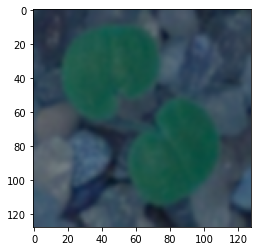

In [180]:
y_pred = encoder.inverse_transform(y_pred)

index = 2
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred[index])

Predicted label: Loose Silky-bent


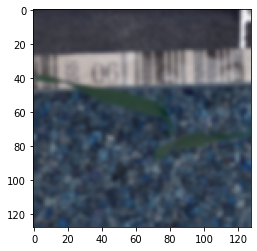

In [181]:
index = 3
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred[index])

Predicted label: Loose Silky-bent


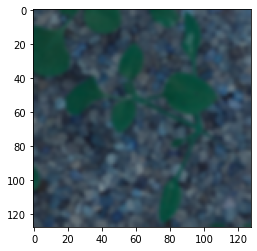

In [182]:
index = 33
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred[index])

Predicted label: Common Chickweed


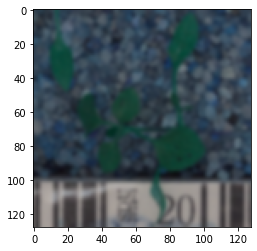

In [183]:
index = 36
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred[index])

Predicted label: Charlock


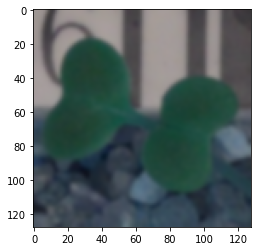

In [184]:
index = 59
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred[index])

# [Add on] Predict the Label for Test test in the original dataset

### Unzipping Prediction files & Normalize it:

In [ ]:
# Extract Train dataset
path = extract_path+"test/*.png"  # The path to all images in test set.
predictionImg, predictionLabel = get_data(path)

In [97]:
print(predictionImg.shape)
print(predictionLabel.shape)

(794, 128, 128, 3)
(794, 1)


In [100]:
# Saving the data to file for future use [avoiding the extraction]
np.save(save_extracted+'predictionImg.npy', predictionImg)
np.save(save_extracted+'predictionLabel.npy', predictionLabel)
print('saved')

saved


In [157]:
# Load prediction data from directory
predictionImg = np.load(save_extracted+'predictionImg.npy')
predictionLabel = np.load(save_extracted+'predictionLabel.npy', False, True)
predictionImg.shape, predictionLabel.shape

((794, 128, 128, 3), (794, 1))

* Prediction label wouldn't be useful here since it has value as 'test', the model will predict these labels

In [33]:
print('------------------------')
predictionImg = predictionImg.astype('float32')
predictionImg /= 255
print(f'Shape of the Prediction array:{predictionImg.shape}')
print(f'Minimum value in the Prediction Array:{predictionImg.min()}')
print(f'Maximum value in the Prediction Array:{predictionImg.max()}')

------------------------
Shape of the Prediction array:(794, 128, 128, 3)
Minimum value in the Prediction Array:0.0
Maximum value in the Prediction Array:1.0


In [ ]:
for idx, img in enumerate(predictionImg):
  predictionImg[idx] = cv2.GaussianBlur(img, (5, 5), 0)

### Model Prediction

In [55]:
y_pred = model1.predict(predictionImg)
print('Prediction:', y_pred)

Prediction: [[2.9238954e-13 2.9492079e-12 3.7557815e-13 ... 3.1417127e-10
  9.9999976e-01 2.5361106e-07]
 [4.2454244e-04 3.5080863e-08 3.1345128e-04 ... 2.2003389e-06
  1.4252861e-07 4.6645237e-06]
 [2.9590775e-04 6.7101308e-04 2.0623734e-02 ... 9.1414480e-03
  1.3674157e-03 7.8776896e-01]
 ...
 [3.7350607e-09 9.2430419e-05 2.3397240e-06 ... 2.8942688e-05
  2.1397867e-08 9.9917680e-01]
 [1.3775682e-23 9.9983966e-01 1.6032094e-04 ... 2.3730697e-09
  6.1441373e-11 2.4423810e-10]
 [1.1404352e-02 8.4649447e-11 2.6372287e-08 ... 1.3545590e-09
  6.0297883e-10 1.4804550e-08]]


In [56]:
y_pred = encoder.inverse_transform(y_pred)
(unique, counts) = np.unique(y_pred, return_counts=True)
print('Unique:',unique, 'Counts:',counts)

Unique: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet'] Counts: [  5  76  40 106  24  82 150  30  75  49  87  70]


Predicted label: Sugar beet


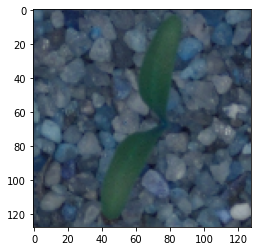

In [58]:
index = 2
plt.imshow(predictionImg[index], cmap='gray')
print("Predicted label:", y_pred[index])


In [ ]:
# Save data to result file
filenames = []
for img in glob(path):
  img_split = img.split("/")
  filenames.append(img_split[len(img_split)-1])
    
df = pd.DataFrame(filenames, columns=['file'])
df['species'] = y_pred
df.head()

In [ ]:
df.to_csv(save_extracted+"result.csv", index=False)

### Happy Learning